In [32]:
import numpy as np
from matplotlib import pyplot as plt

import cv2

import random

In [33]:
def sifter(img1, img2, thresh=0.4):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Use FLANN-based matcher with KDTree for SIFT
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # higher = more accurate but slower

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Get the top 2 matches for each descriptor
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < thresh * n.distance:
            good_matches.append(m)

    # Create color output image
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Create a new image to draw matches side by side
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    match_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    match_img[:h1, :w1] = img1_color
    match_img[:h2, w1:] = img2_color

    # Draw matches manually with thick lines
    for match in good_matches:
        pt1 = tuple(np.round(kp1[match.queryIdx].pt).astype(int))
        pt2 = tuple(np.round(kp2[match.trainIdx].pt).astype(int) + np.array([w1, 0]))

        color = tuple([random.randint(100, 255) for _ in range(3)])
        cv2.circle(match_img, pt1, 5, color, -1)
        cv2.circle(match_img, pt2, 5, color, -1)
        cv2.line(match_img, pt1, pt2, color, 30)


    # # Draw matches
    # img_matches = cv2.drawMatches(
    #     img1, kp1, img2, kp2, good_matches, None,
    #     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    # )

    plt.imshow(match_img)

    return match_img, kp1, kp2, good_matches


In [34]:
def select_pts(img1, img2):
    cv2.namedWindow("Image 1", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Image 2", cv2.WINDOW_NORMAL)

    points_img1 = []
    points_img2 = []

    def click_img1(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(points_img1) < 4:
            points_img1.append((x, y))
            cv2.circle(img1_display, (x, y), 5, (0, 0, 255), -1)
            print(f"Image 1 - Point {len(points_img1)}: ({x}, {y})")

    def click_img2(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(points_img2) < 4:
            points_img2.append((x, y))
            cv2.circle(img2_display, (x, y), 5, (0, 255, 0), -1)
            print(f"Image 2 - Point {len(points_img2)}: ({x}, {y})")

    # Make copies for display
    img1_display = img1.copy()
    img2_display = img2.copy()

    cv2.setMouseCallback("Image 1", click_img1)
    cv2.setMouseCallback("Image 2", click_img2)

    print("Click 4 points in each image. Press ESC when done.")

    while True:
        cv2.imshow("Image 1", img1_display)
        cv2.imshow("Image 2", img2_display)
        key = cv2.waitKey(1)

        if key == 27:  # ESC key to break
            break

        if len(points_img1) == 4 and len(points_img2) == 4:
            print("\n✅ Done collecting points!")
            break

        if key == ord('c'):
            points_img1.clear()
            points_img2.clear()
            img1_display = img1.copy()
            img2_display = img2.copy()

    cv2.destroyAllWindows()

    # Convert to numpy arrays
    pts1 = np.array(points_img1, dtype=np.float32)
    pts2 = np.array(points_img2, dtype=np.float32)

    print("Points in Image 1:", pts1)
    print("Points in Image 2:", pts2)
    return pts1, pts2

In [35]:
def preview_stitch(img_left, img_right, M):
    canvas_width = 15000
    canvas_height = 4000
    
    warped_right = cv2.warpPerspective(img_right, M, (canvas_width, canvas_height))

    canvas = np.zeros_like(warped_right)
    canvas[:img_left.shape[0], :img_left.shape[1]] = img_left

    mask = np.any(warped_right != [0, 0, 0], axis=2)

    canvas[mask] = warped_right[mask]

    plt.figure(figsize=(20, 10))
    plt.imshow(canvas);

def stitch_by_sift(img_left, img_right, thresh=0.4):
    mask, kp1, kp2, good_matches = sifter(cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY), cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY), thresh)

    src_pts = []
    dst_pts = []

    for i in range(len(good_matches)):
        src_pts.append(kp1[good_matches[i].queryIdx].pt)
        dst_pts.append(kp2[good_matches[i].trainIdx].pt)

    src_pts = np.array(src_pts, dtype=np.float32)
    dst_pts = np.array(dst_pts, dtype=np.float32)

    H, mask = cv2.findHomography(dst_pts, src_pts, method=cv2.RANSAC, ransacReprojThreshold=3.0)
    preview_stitch(img_left, img_right, H)

def stitch(left_pts, right_pts, img_left, img_right):
    canvas_width = 15000
    canvas_height = 4000

    M = cv2.getPerspectiveTransform(right_pts, left_pts)
    warped_right = cv2.warpPerspective(img_right, M, (canvas_width, canvas_height))

    canvas = np.zeros_like(warped_right)
    canvas[:img_left.shape[0], :img_left.shape[1]] = img_left

    mask = np.any(warped_right != [0, 0, 0], axis=2)

    canvas[mask] = warped_right[mask]

    plt.figure(figsize=(20, 10))
    plt.imshow(canvas);

def stitch_cv2(img_left, img_right):
    stitcher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)
    stitcher.setPanoConfidenceThresh(0)
    stitcher.setWaveCorrection(True)

    status, stitched = stitcher.stitch([img_left, img_right])

    # Check result
    if status == cv2.Stitcher_OK:
        print("Stitching succeeded!")
        plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
        # cv2.imwrite("stitched_result.jpg", stitched)
    else:
        print("Stitching failed. Error code:", status)

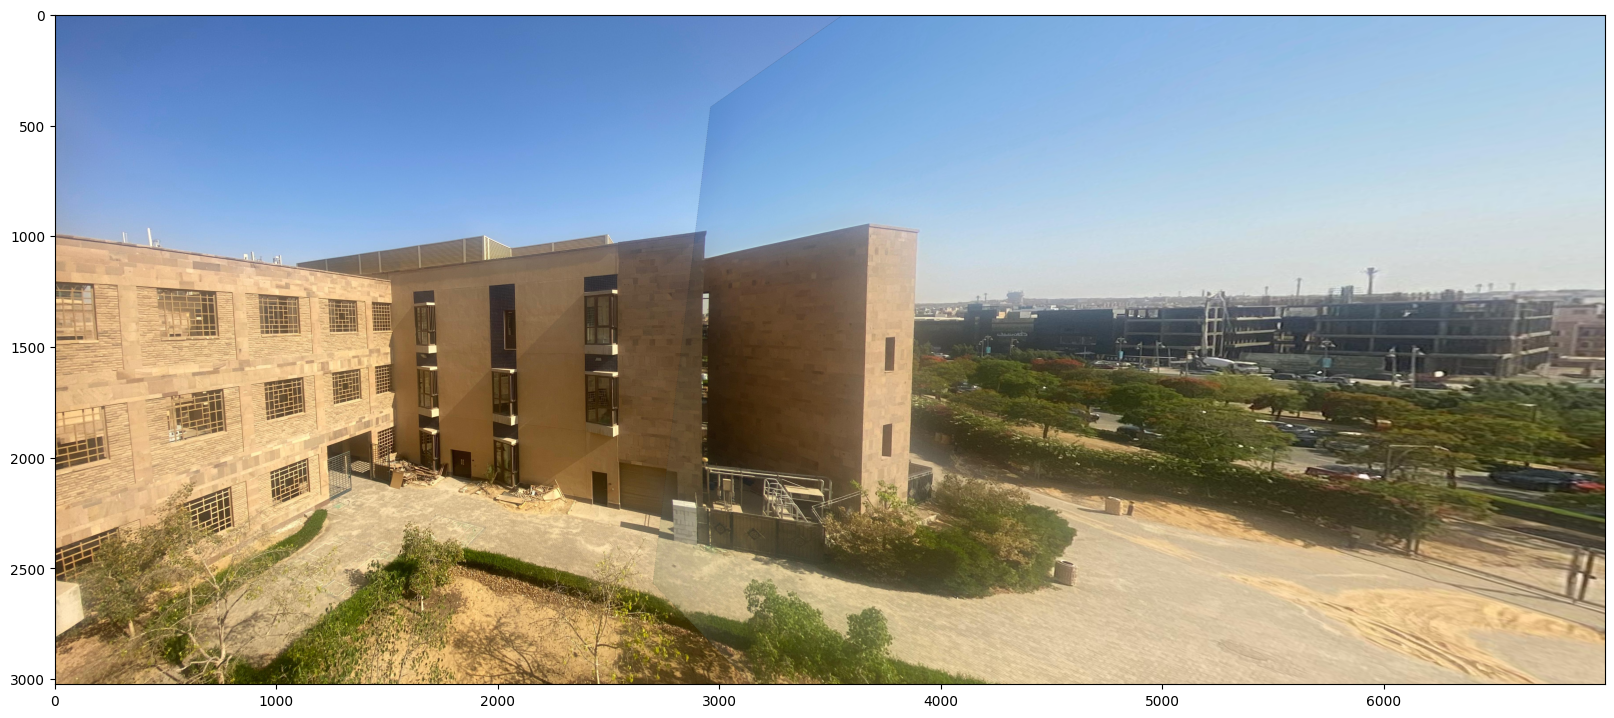

In [70]:
img_left = plt.imread('data/left_building.jpeg')
img_right = plt.imread('data/right_building.jpeg')

left_pts = np.array([
    [2953,1260],
    [3680,945],
    [3785,1615],
    [2945,1750]
], dtype=np.float32)

right_pts = np.array([
    [170,1165],
    [935,950],
    [1070,1515],
    [255,1790]
], dtype=np.float32)

stitch(left_pts, right_pts, img_left, img_right)

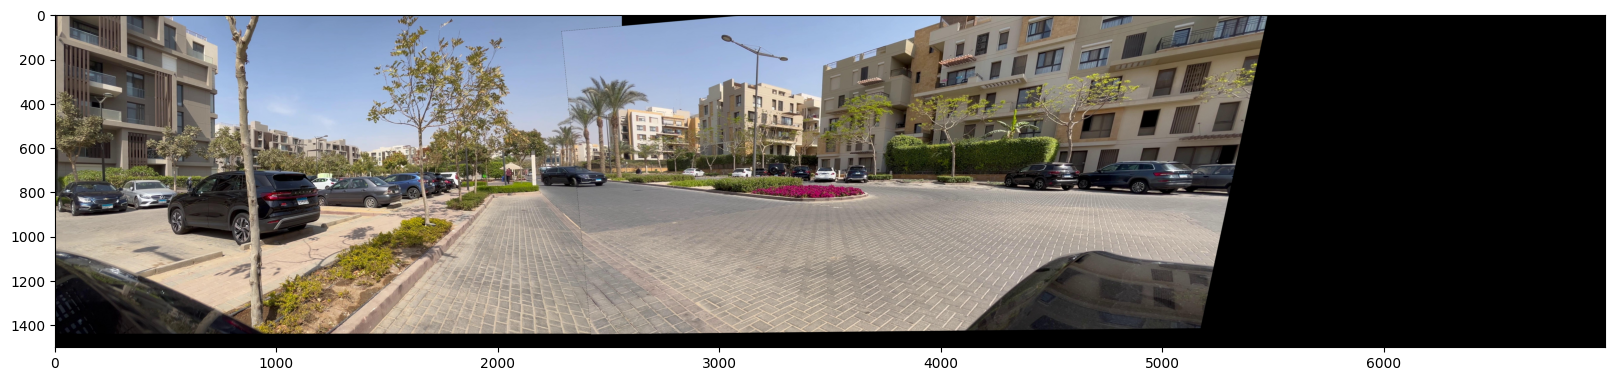

In [ ]:
img_left = plt.imread('data/left_street.jpeg')
img_right = plt.imread('data/right_street.jpeg')

left_pts = np.array([
    [2458,467],
    [2400,987],
    [2552,733],
    [2364,725]
], dtype=np.float32)

right_pts = np.array([
    [127,378],
    [24,913],
    [197,650],
    [13,632]
], dtype=np.float32)

stitch(left_pts, right_pts, img_left, img_right)

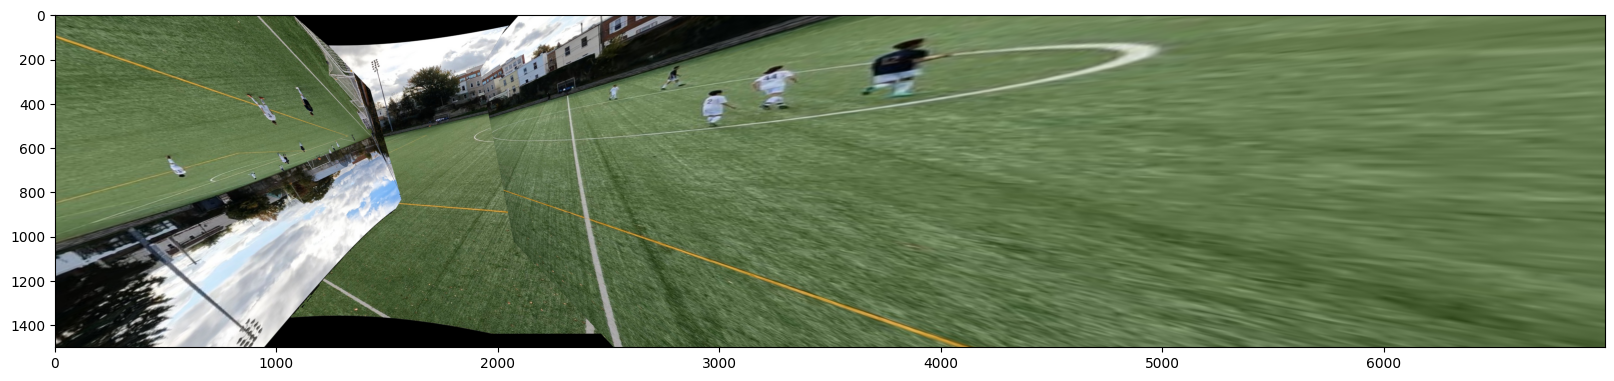

In [46]:
img_left = plt.imread('data/left_soccer.jpeg')
img_right = plt.imread('data/right_soccer.jpeg')

left_pts = np.array([
    [2228,354],
    [2466,401],
    [2132,571],
    [2403,921]
], dtype=np.float32)

right_pts = np.array([
    [472,394],
    [615,493],
    [327,577],
    [546,901]
], dtype=np.float32)

stitch(left_pts, right_pts, img_left, img_right)

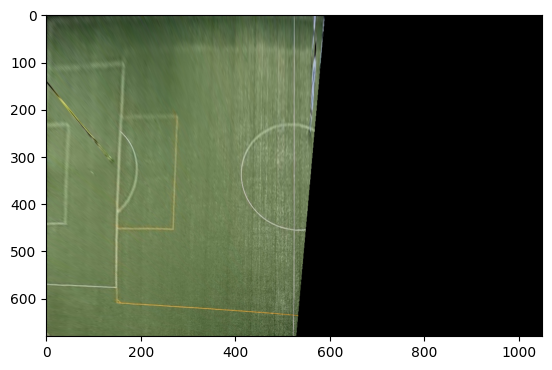

In [52]:
left_borders = np.array([
    [672, 863],
    [1468,557],
    [2344,364],
    [2358, 467],
], dtype=np.float32)

right_borders = np.array([
    [2197,808],
    [1267,535],
    [535,434],
    [534,523],
], dtype=np.float32)

M = cv2.getPerspectiveTransform(left_borders, np.array([
    [0,68],
    [0,0],
    [52.5, 0],
    [52.5, 34],
], dtype=np.float32)*10)

warpped = cv2.warpPerspective(img_left, M, (1050, 680))
plt.imshow(warpped);

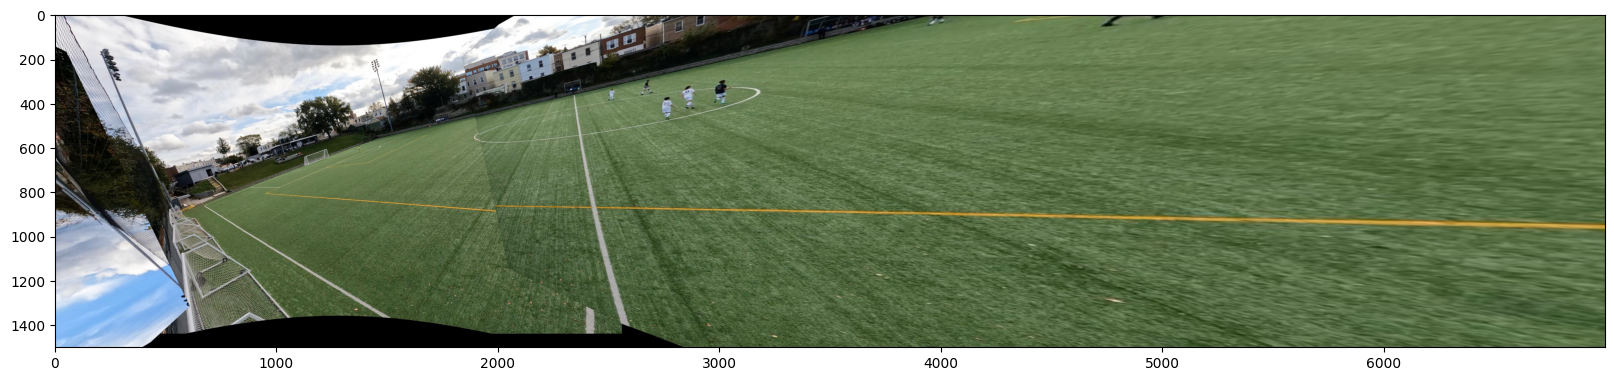

In [67]:
right_borders_virtual = np.array([
    [105,68],
    [105,0],
    [52.5,0],
    [52.5,34],
], dtype=np.float32) * 10

pts_reshaped = right_borders_virtual.reshape(-1, 1, 2)
right_extrapolation = cv2.perspectiveTransform(pts_reshaped, np.linalg.inv(M))

stitch(right_extrapolation, right_borders, img_left, img_right)

Stitching succeeded!


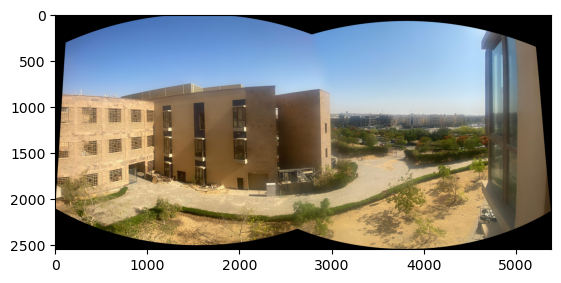

In [5]:
img_left = cv2.imread('data/left_9.jpeg')
img_right = cv2.imread('data/right_9.jpeg')

stitch_cv2(img_left, img_right)

In [9]:
img_left = cv2.imread('data/left_11.jpeg')
img_right = cv2.imread('data/right_11.jpeg')

stitch_cv2(img_left, img_right)

Stitching failed. Error code: 3


Stitching succeeded!


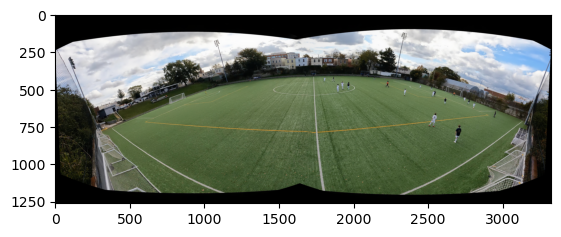

In [10]:
img_left = cv2.imread('data/left_10.jpeg')
img_right = cv2.imread('data/right_10.jpeg')

stitch_cv2(img_left, img_right)

In [30]:
i = 12

img_left = cv2.imread(f'data/left_{i}.jpeg')
img_right = cv2.imread(f'data/right_{i}.jpeg')

stitch_cv2(img_left, img_right)

Stitching failed. Error code: 3


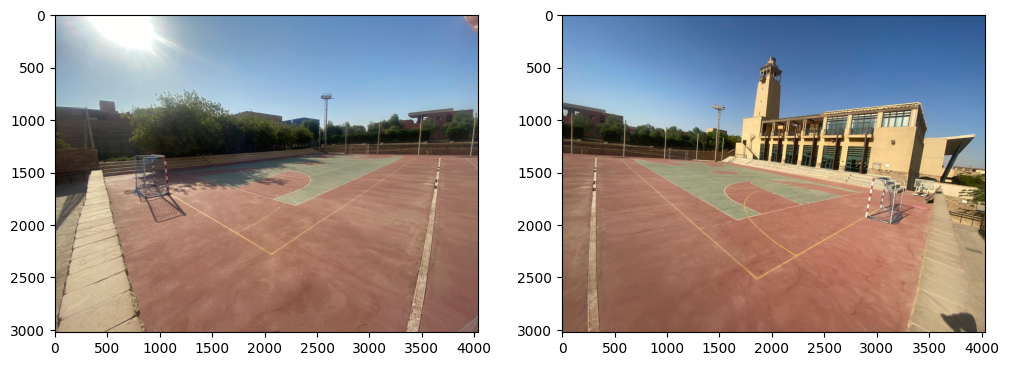

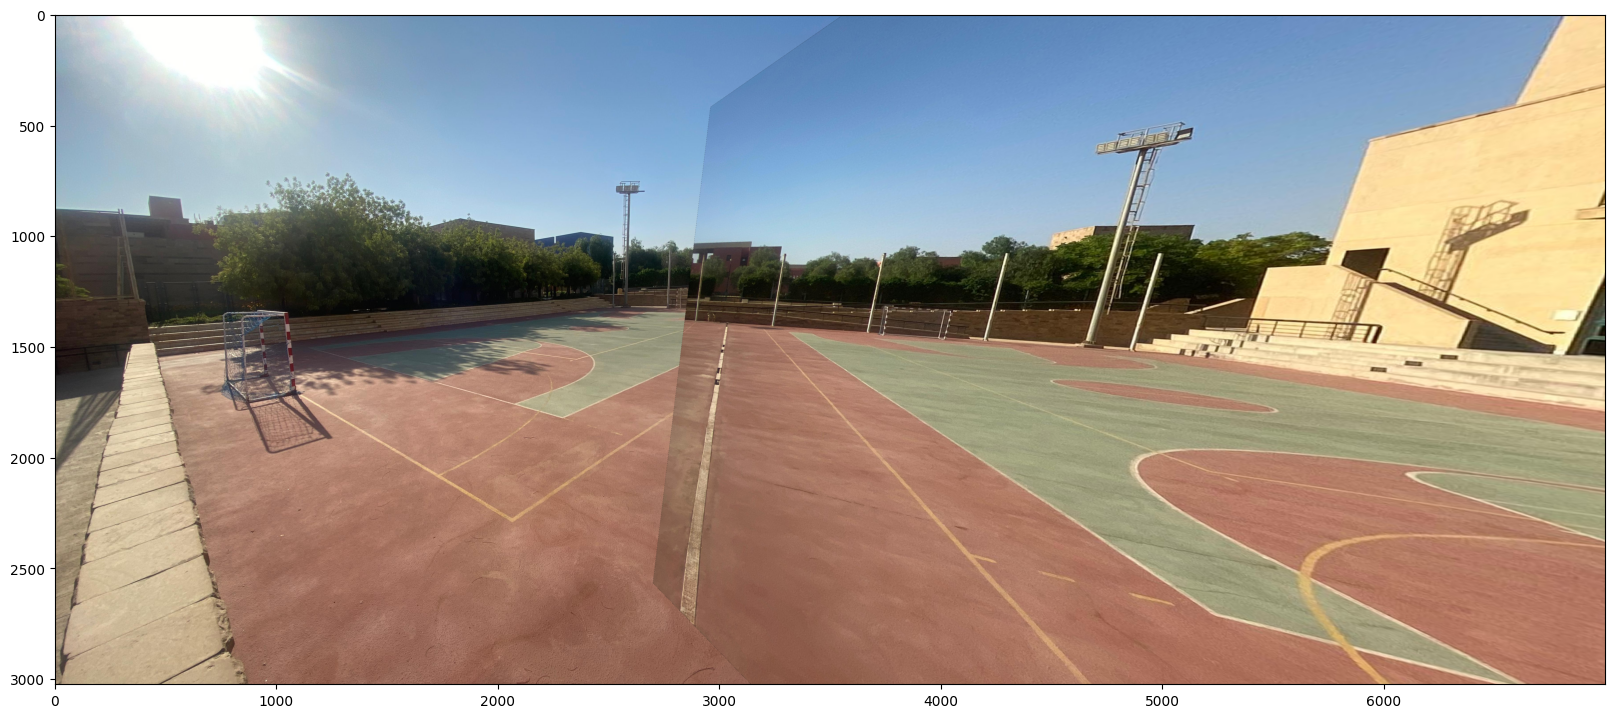

In [109]:
img_left = plt.imread('data/left_1.jpeg')
img_right = plt.imread('data/right_1.jpeg')

plt.figure(figsize=(12, 10))
plt.subplot(1,2,1)
plt.imshow(img_left)
plt.subplot(1,2,2)
plt.imshow(img_right)

left_pts = np.array([
    [2953,1260],
    [3680,945],
    [3785,1615],
    [2945,1750]
], dtype=np.float32)

right_pts = np.array([
    [170,1165],
    [935,950],
    [1070,1515],
    [255,1790]
], dtype=np.float32)

stitch(left_pts, right_pts, img_left, img_right)

QObject::moveToThread: Current thread (0x1ba589f0) is not the object's thread (0x1b690360).
Cannot move to target thread (0x1ba589f0)

QObject::moveToThread: Current thread (0x1ba589f0) is not the object's thread (0x1b690360).
Cannot move to target thread (0x1ba589f0)

QObject::moveToThread: Current thread (0x1ba589f0) is not the object's thread (0x1b690360).
Cannot move to target thread (0x1ba589f0)

QObject::moveToThread: Current thread (0x1ba589f0) is not the object's thread (0x1b690360).
Cannot move to target thread (0x1ba589f0)

QObject::moveToThread: Current thread (0x1ba589f0) is not the object's thread (0x1b690360).
Cannot move to target thread (0x1ba589f0)

QObject::moveToThread: Current thread (0x1ba589f0) is not the object's thread (0x1b690360).
Cannot move to target thread (0x1ba589f0)

QObject::moveToThread: Current thread (0x1ba589f0) is not the object's thread (0x1b690360).
Cannot move to target thread (0x1ba589f0)

QObject::moveToThread: Current thread (0x1ba589f0) is n

Click 4 points in each image. Press ESC when done.
Image 2 - Point 1: (363, 1719)
Image 1 - Point 1: (3492, 1919)
Image 1 - Point 2: (3591, 2224)
Image 2 - Point 2: (384, 2031)
Image 1 - Point 3: (3993, 1964)
Image 2 - Point 3: (799, 1753)
Image 2 - Point 4: (614, 2293)
Image 1 - Point 4: (3928, 2579)

✅ Done collecting points!
Points in Image 1: [[3492. 1919.]
 [3591. 2224.]
 [3993. 1964.]
 [3928. 2579.]]
Points in Image 2: [[ 363. 1719.]
 [ 384. 2031.]
 [ 799. 1753.]
 [ 614. 2293.]]


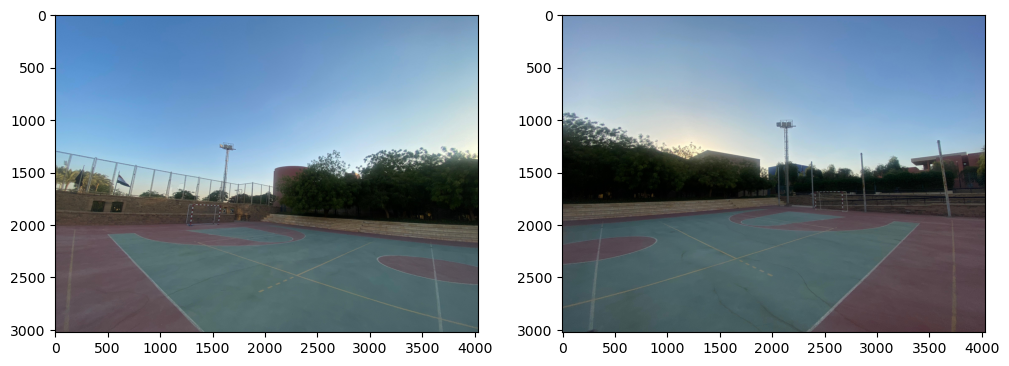

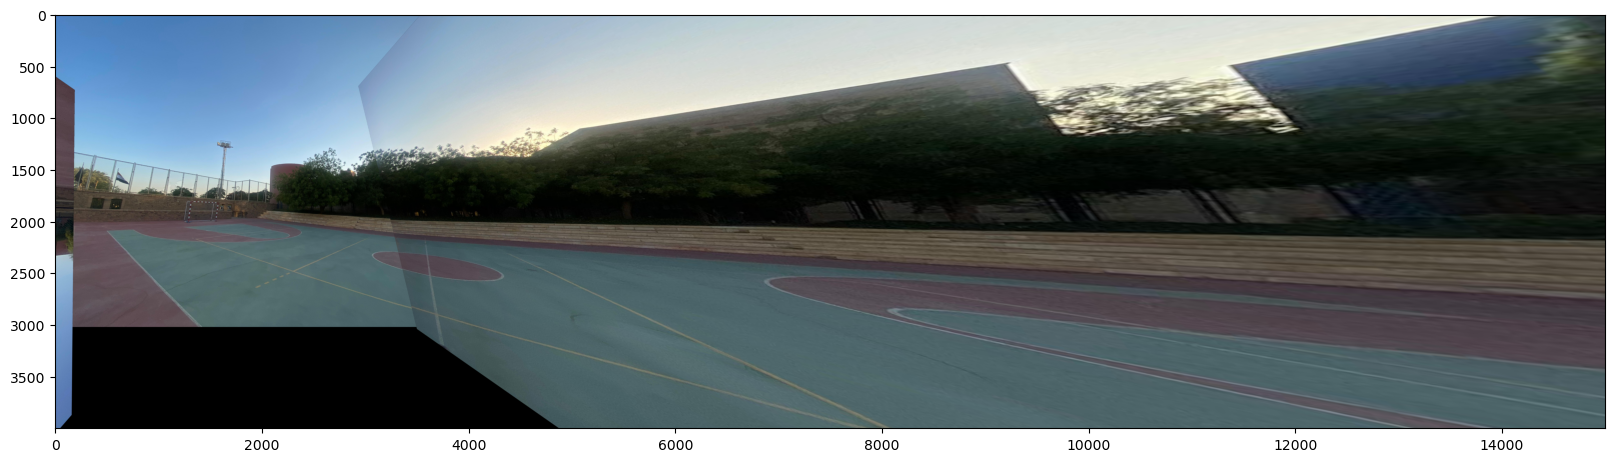

In [37]:
i = 12

img_left = plt.imread(f'data/left_{i}.jpeg')
img_right = plt.imread(f'data/right_{i}.jpeg')
pts_left, pts_right = select_pts(cv2.cvtColor(img_left, cv2.COLOR_RGB2BGR), cv2.cvtColor(img_right, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(12, 10))
plt.subplot(1,2,1)
plt.imshow(img_left)
plt.subplot(1,2,2)
plt.imshow(img_right)

stitch(pts_left, pts_right, img_left, img_right)

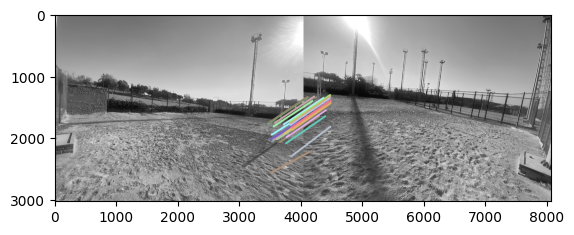

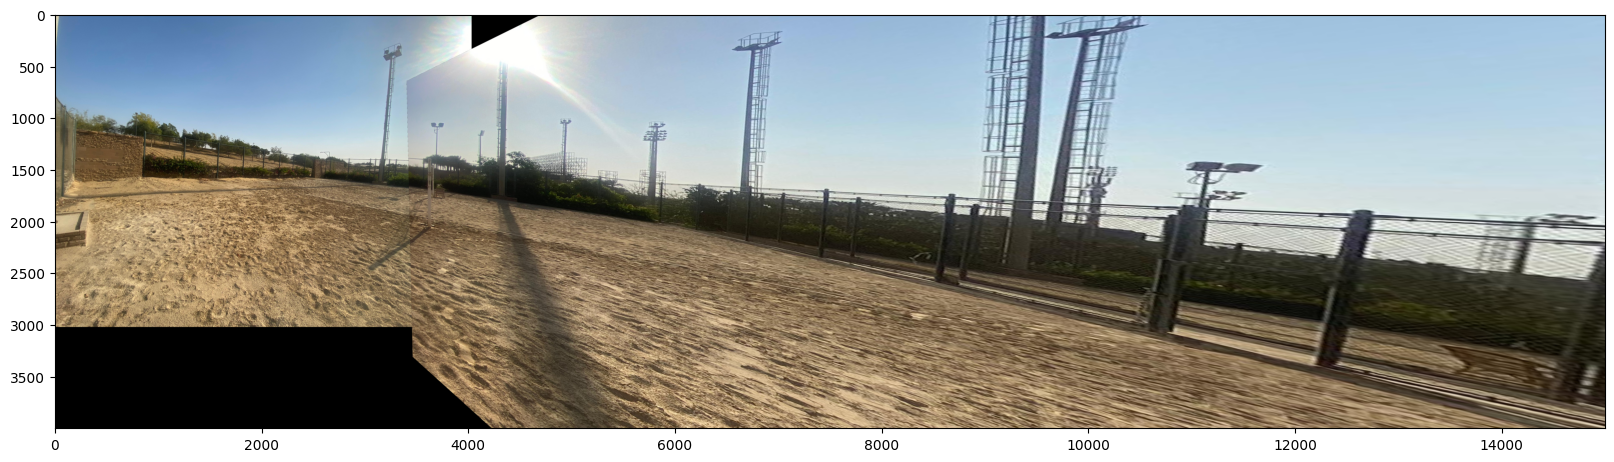

In [ ]:
i = 6

img_left = plt.imread(f'data/left_{i}.jpeg')
img_right = plt.imread(f'data/right_{i}.jpeg')

stitch_by_sift(img_left, img_right, 0.4)